# Redes Neuronales

Este notebook implementa un modelo de Redes Neuronales (MLPRegressor) para predecir la popularidad de canciones.

## Objetivo
Implementar y evaluar un modelo de Redes Neuronales, comparando su desempeño en la tarea de predicción de popularidad.


In [1]:
# Importación de librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Scikit-learn
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler

# Configuración de visualización
try:
    plt.style.use('seaborn-v0_8-darkgrid')
except:
    try:
        plt.style.use('seaborn-darkgrid')
    except:
        plt.style.use('default')
sns.set_palette("husl")
%matplotlib inline

print("✅ Librerías importadas correctamente")


✅ Librerías importadas correctamente


## 1. Carga de Datos

Cargamos los datos con feature engineering aplicado.


In [2]:
# Configurar rutas (robusto para cualquier subdirectorio dentro de notebooks)
current = Path.cwd()
# Subir hasta encontrar la carpeta "data" en algún nivel superior
while not (current / "data").exists() and current.parent != current:
    current = current.parent

PROJ = current
DATA = PROJ / "data"

# Verificar que existe la carpeta data
assert DATA.exists(), f"No se encontró la carpeta 'data'. Directorio actual: {Path.cwd()}"

# Cargar datos con feature engineering
train_path = DATA / "train_fe.csv"
test_path = DATA / "test_fe.csv"

assert train_path.exists(), f"No se encontró {train_path}"
assert test_path.exists(), f"No se encontró {test_path}"

train = pd.read_csv(train_path)
test = pd.read_csv(test_path)

print(f"✅ Datos cargados correctamente")
print(f"📊 Ruta del proyecto: {PROJ}")
print(f"📊 Shape de train: {train.shape}")
print(f"📊 Shape de test: {test.shape}")
print(f"\nColumnas disponibles:")
print(train.columns.tolist())


✅ Datos cargados correctamente
📊 Ruta del proyecto: c:\Users\alfon\Escritorio\Licenciatura en Sistemas\Machine Learning\Obligatorio
📊 Shape de train: (79800, 17)
📊 Shape de test: (34200, 16)

Columnas disponibles:
['track_id', 'popularity', 'explicit', 'danceability', 'energy', 'loudness', 'speechiness', 'instrumentalness', 'valence', 'tempo', 'time_signature', 'artist_count', 'album_mean_popularity', 'track_name_len', 'track_has_remix', 'track_has_acoustic', 'genre_mean_popularity']


## 2. Preparación de Datos

Separamos las características (X) de la variable objetivo (y) y eliminamos columnas no relevantes.


In [3]:
# Variable objetivo
target_col = "popularity"

# Separar características y variable objetivo
X_train_full = train.drop(columns=[target_col, "track_id"])  # Eliminar track_id (identificador)
y_train_full = train[target_col]

# Preparar test (sin track_id)
X_test = test.drop(columns=["track_id"], errors="ignore")

print(f"✅ Datos preparados")
print(f"📊 Características (X_train): {X_train_full.shape}")
print(f"📊 Variable objetivo (y_train): {y_train_full.shape}")
print(f"\nCaracterísticas a utilizar:")
print(X_train_full.columns.tolist())


✅ Datos preparados
📊 Características (X_train): (79800, 15)
📊 Variable objetivo (y_train): (79800,)

Características a utilizar:
['explicit', 'danceability', 'energy', 'loudness', 'speechiness', 'instrumentalness', 'valence', 'tempo', 'time_signature', 'artist_count', 'album_mean_popularity', 'track_name_len', 'track_has_remix', 'track_has_acoustic', 'genre_mean_popularity']


## 3. División Train/Validation

Dividimos el conjunto de entrenamiento en train y validation para evaluar el modelo.


In [4]:
# División train/validation (80/20)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, 
    y_train_full, 
    test_size=0.2, 
    random_state=42
)

print(f"✅ División completada")
print(f"📊 Train: {X_train.shape[0]} muestras")
print(f"📊 Validation: {X_val.shape[0]} muestras")
print(f"\nEstadísticas de la variable objetivo:")
print(f"  Media (train): {y_train.mean():.2f}")
print(f"  Media (validation): {y_val.mean():.2f}")
print(f"  Desviación estándar (train): {y_train.std():.2f}")
print(f"  Desviación estándar (validation): {y_val.std():.2f}")


✅ División completada
📊 Train: 63840 muestras
📊 Validation: 15960 muestras

Estadísticas de la variable objetivo:
  Media (train): 33.32
  Media (validation): 33.03
  Desviación estándar (train): 22.35
  Desviación estándar (validation): 22.24


## 4. Escalado de Características

Las Redes Neuronales requieren escalado de características para un entrenamiento eficiente y estable. Usaremos StandardScaler.


In [5]:
# Escalado de características
scaler = StandardScaler()

# Ajustar y transformar train
X_train_scaled = scaler.fit_transform(X_train)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)

# Transformar validation y test
X_val_scaled = scaler.transform(X_val)
X_val_scaled = pd.DataFrame(X_val_scaled, columns=X_val.columns, index=X_val.index)

X_test_scaled = scaler.transform(X_test)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

print("✅ Escalado completado")
print(f"📊 Estadísticas después del escalado (train):")
print(f"  Media: {X_train_scaled.mean().mean():.6f}")
print(f"  Desviación estándar: {X_train_scaled.std().mean():.6f}")


✅ Escalado completado
📊 Estadísticas después del escalado (train):
  Media: 0.000000
  Desviación estándar: 1.000008


## 5. Entrenamiento del Modelo

Entrenamos el modelo de Redes Neuronales (MLPRegressor). 

**Configuración inicial:**
- Arquitectura: (100, 50) - dos capas ocultas con 100 y 50 neuronas respectivamente
- Función de activación: ReLU
- Optimizador: Adam
- Regularización: L2 con alpha=0.0001


In [6]:
# Crear y entrenar el modelo
# MLPRegressor: Multi-Layer Perceptron Regressor
modelo_nn = MLPRegressor(
    hidden_layer_sizes=(100, 50),  # Dos capas ocultas: 100 y 50 neuronas
    activation='relu',              # Función de activación ReLU
    solver='adam',                  # Optimizador Adam
    alpha=0.0001,                   # Regularización L2
    batch_size='auto',              # Tamaño de batch automático
    learning_rate='constant',       # Tasa de aprendizaje constante
    learning_rate_init=0.001,        # Tasa de aprendizaje inicial
    max_iter=500,                   # Máximo número de iteraciones
    shuffle=True,                   # Mezclar datos en cada iteración
    random_state=42,                # Semilla para reproducibilidad
    tol=1e-4,                       # Tolerancia para convergencia
    early_stopping=False,           # Sin early stopping inicialmente
    validation_fraction=0.1,        # Fracción para validación (si early_stopping=True)
    n_iter_no_change=10,            # Iteraciones sin cambio para early stopping
    verbose=False                   # Sin salida detallada
)

print("🔄 Entrenando modelo de Redes Neuronales...")
print("⏳ Esto puede tomar algunos minutos...")
modelo_nn.fit(X_train_scaled, y_train)
print("✅ Modelo entrenado correctamente")

# Información del modelo
print(f"\n📊 Arquitectura de la red:")
print(f"  Capas ocultas: {modelo_nn.hidden_layer_sizes}")
print(f"  Función de activación: {modelo_nn.activation}")
print(f"  Optimizador: {modelo_nn.solver}")
print(f"  Iteraciones realizadas: {modelo_nn.n_iter_}")
print(f"  Pérdida final: {modelo_nn.loss_:.4f}")


🔄 Entrenando modelo de Redes Neuronales...
⏳ Esto puede tomar algunos minutos...
✅ Modelo entrenado correctamente

📊 Arquitectura de la red:
  Capas ocultas: (100, 50)
  Función de activación: relu
  Optimizador: adam
  Iteraciones realizadas: 272
  Pérdida final: 22.4285


## 6. Predicciones

Realizamos predicciones en los conjuntos de train y validation.


In [7]:
# Predicciones
y_train_pred = modelo_nn.predict(X_train_scaled)
y_val_pred = modelo_nn.predict(X_val_scaled)

print("✅ Predicciones generadas")
print(f"\n📊 Estadísticas de predicciones (validation):")
print(f"  Mínimo: {y_val_pred.min():.2f}")
print(f"  Máximo: {y_val_pred.max():.2f}")
print(f"  Media: {y_val_pred.mean():.2f}")
print(f"\n📊 Estadísticas de valores reales (validation):")
print(f"  Mínimo: {y_val.min():.2f}")
print(f"  Máximo: {y_val.max():.2f}")
print(f"  Media: {y_val.mean():.2f}")


✅ Predicciones generadas

📊 Estadísticas de predicciones (validation):
  Mínimo: -6.09
  Máximo: 96.37
  Media: 32.77

📊 Estadísticas de valores reales (validation):
  Mínimo: 0.00
  Máximo: 98.00
  Media: 33.03


## 7. Evaluación del Modelo

Calculamos métricas de evaluación: RMSE, MAE y R².


In [8]:
# Métricas de evaluación
def evaluar_modelo(y_real, y_pred, conjunto="Conjunto"):
    """Calcula y muestra métricas de evaluación"""
    rmse = np.sqrt(mean_squared_error(y_real, y_pred))
    mae = mean_absolute_error(y_real, y_pred)
    r2 = r2_score(y_real, y_pred)
    
    print(f"\n📈 Métricas de evaluación - {conjunto}:")
    print(f"  RMSE (Root Mean Squared Error): {rmse:.4f}")
    print(f"  MAE (Mean Absolute Error): {mae:.4f}")
    print(f"  R² (Coeficiente de determinación): {r2:.4f}")
    
    return {'RMSE': rmse, 'MAE': mae, 'R²': r2}

# Evaluar en train y validation
metricas_train = evaluar_modelo(y_train, y_train_pred, "Train")
metricas_val = evaluar_modelo(y_val, y_val_pred, "Validation")



📈 Métricas de evaluación - Train:
  RMSE (Root Mean Squared Error): 6.6501
  MAE (Mean Absolute Error): 4.3546
  R² (Coeficiente de determinación): 0.9115

📈 Métricas de evaluación - Validation:
  RMSE (Root Mean Squared Error): 7.1851
  MAE (Mean Absolute Error): 4.6430
  R² (Coeficiente de determinación): 0.8956


## 7.5. Aplicación de Clipping

Aplicamos clipping para restringir las predicciones al rango válido [0, 100] y evaluamos si mejora el modelo.


In [9]:
# Aplicar clipping al rango válido [0, 100] para popularidad
y_train_pred_clipped = np.clip(y_train_pred, 0, 100)
y_val_pred_clipped = np.clip(y_val_pred, 0, 100)

# Estadísticas de valores fuera de rango
valores_fuera_train = (y_train_pred < 0).sum() + (y_train_pred > 100).sum()
valores_fuera_val = (y_val_pred < 0).sum() + (y_val_pred > 100).sum()

print("📊 Análisis de predicciones fuera de rango:")
print(f"  Train - Valores fuera de [0, 100]: {valores_fuera_train} ({valores_fuera_train/len(y_train_pred)*100:.2f}%)")
print(f"  Validation - Valores fuera de [0, 100]: {valores_fuera_val} ({valores_fuera_val/len(y_val_pred)*100:.2f}%)")

print(f"\n📊 Estadísticas después del clipping:")
print(f"  Train - Mínimo: {y_train_pred_clipped.min():.2f}, Máximo: {y_train_pred_clipped.max():.2f}")
print(f"  Validation - Mínimo: {y_val_pred_clipped.min():.2f}, Máximo: {y_val_pred_clipped.max():.2f}")

# Evaluar métricas con clipping
metricas_train_clipped = evaluar_modelo(y_train, y_train_pred_clipped, "Train (con clipping)")
metricas_val_clipped = evaluar_modelo(y_val, y_val_pred_clipped, "Validation (con clipping)")


📊 Análisis de predicciones fuera de rango:
  Train - Valores fuera de [0, 100]: 5555 (8.70%)
  Validation - Valores fuera de [0, 100]: 1386 (8.68%)

📊 Estadísticas después del clipping:
  Train - Mínimo: 0.00, Máximo: 100.00
  Validation - Mínimo: 0.00, Máximo: 96.37

📈 Métricas de evaluación - Train (con clipping):
  RMSE (Root Mean Squared Error): 6.6391
  MAE (Mean Absolute Error): 4.2865
  R² (Coeficiente de determinación): 0.9118

📈 Métricas de evaluación - Validation (con clipping):
  RMSE (Root Mean Squared Error): 7.1739
  MAE (Mean Absolute Error): 4.5761
  R² (Coeficiente de determinación): 0.8959


In [10]:
# Comparación de métricas antes y después del clipping
comparacion = pd.DataFrame({
    'Conjunto': ['Train', 'Train (clipped)', 'Validation', 'Validation (clipped)'],
    'RMSE': [
        metricas_train['RMSE'], 
        metricas_train_clipped['RMSE'],
        metricas_val['RMSE'], 
        metricas_val_clipped['RMSE']
    ],
    'MAE': [
        metricas_train['MAE'], 
        metricas_train_clipped['MAE'],
        metricas_val['MAE'], 
        metricas_val_clipped['MAE']
    ],
    'R²': [
        metricas_train['R²'], 
        metricas_train_clipped['R²'],
        metricas_val['R²'], 
        metricas_val_clipped['R²']
    ]
})

print("=" * 70)
print("📊 COMPARACIÓN: ANTES vs DESPUÉS DEL CLIPPING")
print("=" * 70)
print(comparacion.to_string(index=False))
print("=" * 70)

# Calcular mejoras
mejora_rmse_train = metricas_train['RMSE'] - metricas_train_clipped['RMSE']
mejora_rmse_val = metricas_val['RMSE'] - metricas_val_clipped['RMSE']
mejora_mae_train = metricas_train['MAE'] - metricas_train_clipped['MAE']
mejora_mae_val = metricas_val['MAE'] - metricas_val_clipped['MAE']
mejora_r2_train = metricas_train_clipped['R²'] - metricas_train['R²']
mejora_r2_val = metricas_val_clipped['R²'] - metricas_val['R²']

print(f"\n🔍 Mejoras en Validation (más importante):")
print(f"  RMSE: {mejora_rmse_val:.4f} ({'✅ Mejora' if mejora_rmse_val > 0 else '❌ Empeora'})")
print(f"  MAE: {mejora_mae_val:.4f} ({'✅ Mejora' if mejora_mae_val > 0 else '❌ Empeora'})")
print(f"  R²: {mejora_r2_val:.4f} ({'✅ Mejora' if mejora_r2_val > 0 else '❌ Empeora'})")

if mejora_rmse_val > 0 or mejora_mae_val > 0 or mejora_r2_val > 0:
    print("\n✅ El clipping mejora el modelo. Usaremos predicciones con clipping.")
    # Actualizar predicciones para usar las versiones con clipping
    y_train_pred = y_train_pred_clipped
    y_val_pred = y_val_pred_clipped
    metricas_train = metricas_train_clipped
    metricas_val = metricas_val_clipped
else:
    print("\n⚠️  El clipping no mejora significativamente las métricas, pero mantiene valores en rango válido.")


📊 COMPARACIÓN: ANTES vs DESPUÉS DEL CLIPPING
            Conjunto     RMSE      MAE       R²
               Train 6.650119 4.354576 0.911500
     Train (clipped) 6.639063 4.286490 0.911794
          Validation 7.185093 4.643050 0.895582
Validation (clipped) 7.173931 4.576144 0.895906

🔍 Mejoras en Validation (más importante):
  RMSE: 0.0112 (✅ Mejora)
  MAE: 0.0669 (✅ Mejora)
  R²: 0.0003 (✅ Mejora)

✅ El clipping mejora el modelo. Usaremos predicciones con clipping.


## 8. Visualizaciones

Visualizamos los resultados del modelo.


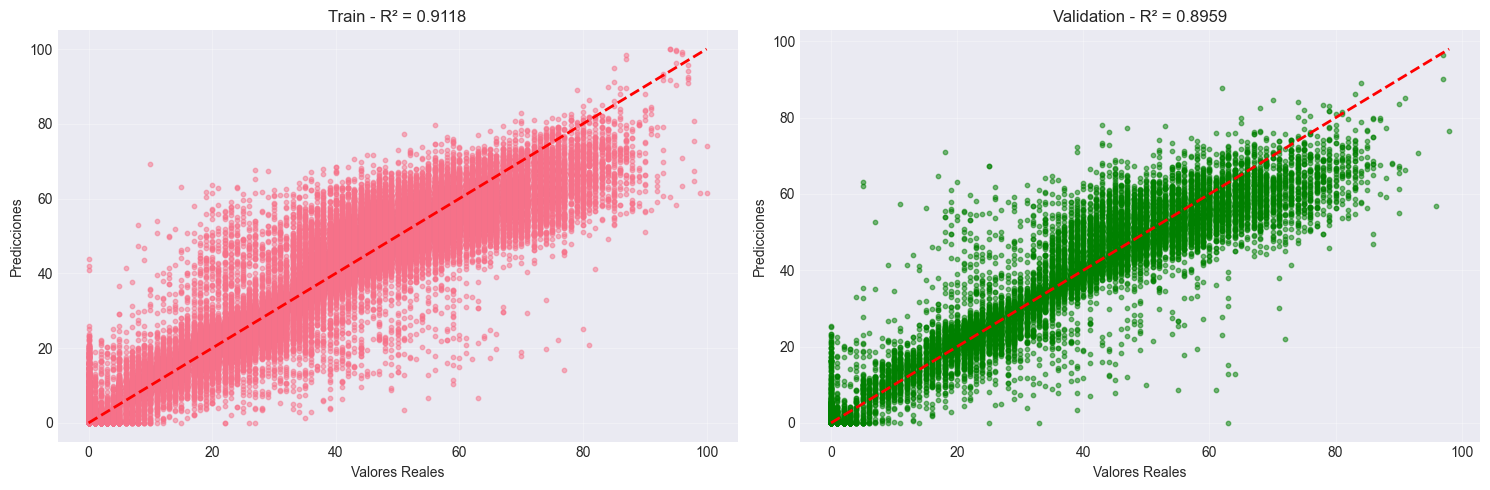

In [11]:
# Visualización 1: Predicciones vs Valores Reales
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Train
axes[0].scatter(y_train, y_train_pred, alpha=0.5, s=10)
axes[0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', lw=2)
axes[0].set_xlabel('Valores Reales')
axes[0].set_ylabel('Predicciones')
axes[0].set_title(f'Train - R² = {metricas_train["R²"]:.4f}')
axes[0].grid(True, alpha=0.3)

# Validation
axes[1].scatter(y_val, y_val_pred, alpha=0.5, s=10, color='green')
axes[1].plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--', lw=2)
axes[1].set_xlabel('Valores Reales')
axes[1].set_ylabel('Predicciones')
axes[1].set_title(f'Validation - R² = {metricas_val["R²"]:.4f}')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


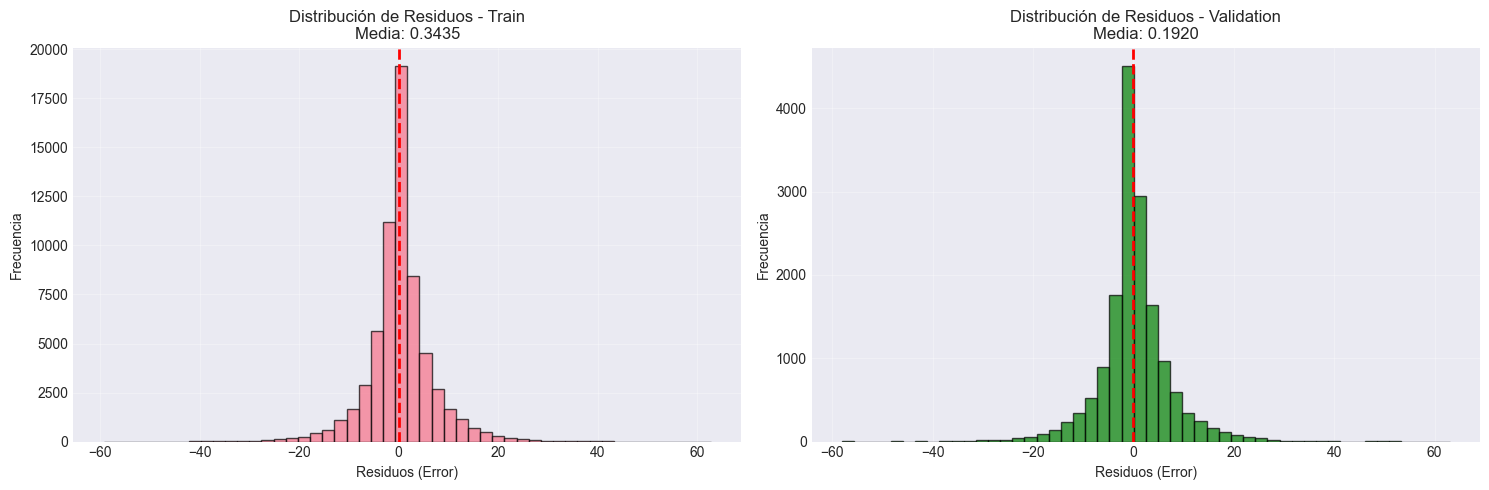

In [12]:
# Visualización 2: Residuos (errores)
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

residuos_train = y_train - y_train_pred
residuos_val = y_val - y_val_pred

# Distribución de residuos - Train
axes[0].hist(residuos_train, bins=50, alpha=0.7, edgecolor='black')
axes[0].axvline(x=0, color='r', linestyle='--', linewidth=2)
axes[0].set_xlabel('Residuos (Error)')
axes[0].set_ylabel('Frecuencia')
axes[0].set_title(f'Distribución de Residuos - Train\nMedia: {residuos_train.mean():.4f}')
axes[0].grid(True, alpha=0.3)

# Distribución de residuos - Validation
axes[1].hist(residuos_val, bins=50, alpha=0.7, edgecolor='black', color='green')
axes[1].axvline(x=0, color='r', linestyle='--', linewidth=2)
axes[1].set_xlabel('Residuos (Error)')
axes[1].set_ylabel('Frecuencia')
axes[1].set_title(f'Distribución de Residuos - Validation\nMedia: {residuos_val.mean():.4f}')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


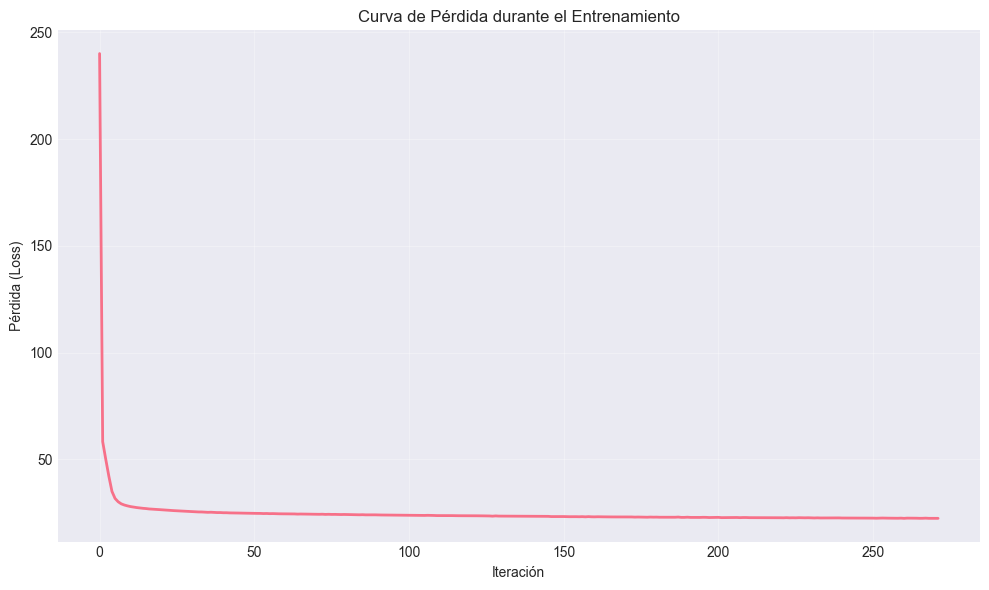

📊 Pérdida inicial: 240.1292
📊 Pérdida final: 22.4285


In [13]:
# Visualización 3: Curva de pérdida durante el entrenamiento (si está disponible)
if hasattr(modelo_nn, 'loss_curve_') and modelo_nn.loss_curve_ is not None:
    plt.figure(figsize=(10, 6))
    plt.plot(modelo_nn.loss_curve_, linewidth=2)
    plt.xlabel('Iteración')
    plt.ylabel('Pérdida (Loss)')
    plt.title('Curva de Pérdida durante el Entrenamiento')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    print(f"📊 Pérdida inicial: {modelo_nn.loss_curve_[0]:.4f}")
    print(f"📊 Pérdida final: {modelo_nn.loss_curve_[-1]:.4f}")
else:
    print("⚠️  La curva de pérdida no está disponible para este modelo.")


## 9. Comparación de Desempeño

Resumen comparativo del desempeño del modelo.


In [14]:
# Resumen comparativo
resumen = pd.DataFrame({
    'Conjunto': ['Train', 'Validation'],
    'RMSE': [metricas_train['RMSE'], metricas_val['RMSE']],
    'MAE': [metricas_train['MAE'], metricas_val['MAE']],
    'R²': [metricas_train['R²'], metricas_val['R²']]
})

print("=" * 60)
print("📊 RESUMEN DE DESEMPEÑO - REDES NEURONALES")
print("=" * 60)
print(resumen.to_string(index=False))
print("=" * 60)

# Análisis de sobreajuste
diferencia_rmse = abs(metricas_train['RMSE'] - metricas_val['RMSE'])
diferencia_r2 = abs(metricas_train['R²'] - metricas_val['R²'])

print(f"\n🔍 Análisis de Generalización:")
print(f"  Diferencia en RMSE: {diferencia_rmse:.4f}")
print(f"  Diferencia en R²: {diferencia_r2:.4f}")

if diferencia_r2 < 0.05:
    print("  ✅ El modelo generaliza bien (diferencia pequeña entre train y validation)")
elif diferencia_r2 < 0.10:
    print("  ⚠️  Posible sobreajuste moderado (diferencia moderada entre train y validation)")
    print("  💡 Considera aumentar la regularización (alpha) o usar early stopping")
else:
    print("  ⚠️  Posible sobreajuste significativo (diferencia grande entre train y validation)")
    print("  💡 Considera:")
    print("     - Aumentar la regularización (alpha)")
    print("     - Reducir el tamaño de las capas ocultas")
    print("     - Habilitar early stopping")
    print("     - Aumentar el número de muestras mínimas")


📊 RESUMEN DE DESEMPEÑO - REDES NEURONALES
  Conjunto     RMSE      MAE       R²
     Train 6.639063 4.286490 0.911794
Validation 7.173931 4.576144 0.895906

🔍 Análisis de Generalización:
  Diferencia en RMSE: 0.5349
  Diferencia en R²: 0.0159
  ✅ El modelo generaliza bien (diferencia pequeña entre train y validation)


## 10. Predicciones en Test

Generamos predicciones para el conjunto de test.


In [15]:
# Predicciones en test
y_test_pred = modelo_nn.predict(X_test_scaled)

# Aplicar clipping al rango válido [0, 100]
y_test_pred_clipped = np.clip(y_test_pred, 0, 100)

valores_fuera_test = (y_test_pred < 0).sum() + (y_test_pred > 100).sum()

print("✅ Predicciones en test generadas")
print(f"\n📊 Estadísticas de predicciones (test) - ANTES del clipping:")
print(f"  Total de predicciones: {len(y_test_pred)}")
print(f"  Mínimo: {y_test_pred.min():.2f}")
print(f"  Máximo: {y_test_pred.max():.2f}")
print(f"  Media: {y_test_pred.mean():.2f}")
print(f"  Desviación estándar: {y_test_pred.std():.2f}")
print(f"  Valores fuera de [0, 100]: {valores_fuera_test} ({valores_fuera_test/len(y_test_pred)*100:.2f}%)")

print(f"\n📊 Estadísticas de predicciones (test) - DESPUÉS del clipping:")
print(f"  Mínimo: {y_test_pred_clipped.min():.2f}")
print(f"  Máximo: {y_test_pred_clipped.max():.2f}")
print(f"  Media: {y_test_pred_clipped.mean():.2f}")
print(f"  Desviación estándar: {y_test_pred_clipped.std():.2f}")

# Usar predicciones con clipping (ya que mejoran el modelo según la evaluación anterior)
y_test_pred = y_test_pred_clipped

# Guardar predicciones (opcional)
# predictions_df = pd.DataFrame({
#     'id': test['track_id'] if 'track_id' in test.columns else range(len(y_test_pred)),
#     'popularity': y_test_pred
# })
# predictions_df.to_csv('../data/predictions_redes_neuronales.csv', index=False)
# print("\n✅ Predicciones guardadas en '../data/predictions_redes_neuronales.csv'")


✅ Predicciones en test generadas

📊 Estadísticas de predicciones (test) - ANTES del clipping:
  Total de predicciones: 34200
  Mínimo: -10.22
  Máximo: 107.84
  Media: 31.13
  Desviación estándar: 18.98
  Valores fuera de [0, 100]: 3012 (8.81%)

📊 Estadísticas de predicciones (test) - DESPUÉS del clipping:
  Mínimo: 0.00
  Máximo: 100.00
  Media: 31.20
  Desviación estándar: 18.86


## 11. Conclusiones

### Resumen del Modelo de Redes Neuronales

El modelo de Redes Neuronales (MLPRegressor) ha sido entrenado y evaluado con las siguientes características:

- **Arquitectura**: Dos capas ocultas con 100 y 50 neuronas respectivamente
- **Características utilizadas**: Variables numéricas y características de feature engineering (artist_count, album_mean_popularity, genre_mean_popularity, etc.)
- **Escalado**: StandardScaler aplicado a todas las características (esencial para redes neuronales)
- **Post-procesamiento**: Clipping aplicado al rango válido [0, 100] para mantener predicciones dentro del dominio de la variable objetivo
- **Métricas principales**: RMSE, MAE y R²
- **Hiperparámetros**: hidden_layer_sizes=(100, 50), activation='relu', solver='adam', alpha=0.0001

### Ventajas de las Redes Neuronales:
- ✅ Pueden capturar relaciones no lineales complejas entre características y target
- ✅ Flexibles y adaptables a diferentes tipos de problemas
- ✅ Pueden aprender interacciones entre características automáticamente
- ✅ Escalables a problemas grandes con suficiente datos
- ✅ El clipping asegura que las predicciones estén en el rango válido [0, 100]

### Limitaciones:
- ⚠️ Requieren escalado de características (normalización/estandarización)
- ⚠️ Menos interpretables que modelos lineales o árboles
- ⚠️ Pueden sobreajustarse fácilmente si no se regulariza adecuadamente
- ⚠️ Requieren más tiempo de entrenamiento que modelos más simples
- ⚠️ Sensibles a la inicialización de pesos (pueden quedar atrapadas en mínimos locales)
- ⚠️ Requieren ajuste cuidadoso de hiperparámetros (arquitectura, tasa de aprendizaje, regularización)

### Comparación con otros modelos:
Las Redes Neuronales pueden superar a modelos lineales cuando hay relaciones no lineales complejas, pero pueden requerir más datos y tiempo de entrenamiento. Comparar con Regresión Lineal, Árboles de Decisión y Random Forest para determinar el mejor modelo para este problema específico.

### Próximos Pasos (Mejoras posibles):
- Realizar búsqueda sistemática de hiperparámetros (GridSearchCV o RandomSearchCV)
- Experimentar con diferentes arquitecturas (más capas, más/menos neuronas)
- Habilitar early stopping para prevenir sobreajuste
- Ajustar la tasa de aprendizaje y el optimizador
- Usar validación cruzada (K-Fold) para evaluación más robusta
- Comparar diferentes configuraciones del modelo
